In [72]:
from collections import Counter, defaultdict
import os
from pathlib import Path
import pickle
import random
import string

import iisignature
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import pandas as pd

import scipy
from sklearn import covariance, ensemble, metrics, random_projection, model_selection, neighbors, neural_network
import sklearn.cluster

import torch
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
import umap
import zarr

plt.rcParams['figure.dpi'] = 200

# Path Signatures for Natural Language Processing

This notebook uses the Standardised Project Gutenberg Corpus (Gerlach and Font-Clos, 2018). To run this notebook, it is necessary that you download a snapshot of the dataset by checking out and running the data extraction code available at https://github.com/pgcorpus/gutenberg. Follow the instructions provided in the Standardised Project Gutenberg Corpus README, making sure to run both *python get_data.py* and *python process_data.py*.

Once you have successfully downloaded the dataset, make sure that the value of the following variable **DATASET_PATH** is set to the correct path containing the dataset (it needs to be the path leading up to the directories *metadata* and *data*):

### Get the Data (Download & Preprocessing)

In [73]:
# !git clone https://github.com/pgcorpus/gutenberg.git

In [74]:
# !cd gutenberg
# !pwd
# # To install any missing dependencies, just run
# !pip install -r requirements.txt

In [75]:
# To get a local copy of the PG data, just run
# !python get_data.py

In [76]:
# To process all the data in the raw/ directory, run below, This will fill in the text/, tokens/ and counts/ folders.
# !python process_data.py

## Read in Dataset

Written text is an example of a high-dimensional data stream. Highly successful and popular machine learning approaches involving such forms of natural language are neural network architectures called transformers. In this notebook, we showcase how to harness the capabilities of path signatures and transformers. Specifically, we consider the challenge of determining whether a text was written by an author that we have not yet encountered in a corpus of unlabelled texts.

At a conceptual level, the approach demonstrated in this notebook uses the following pipeline for processing a stream of text:
* Read in the stream of text corresponding to a literary work
* Tokenize the text into a stream of integers and split into chunks each consisting of 512 tokens (tokens may correspond to words, but also punctuation marks, word stems (e.g. *analys*-) and affixes (e.g. *re*-, -*ing*, *-ed*)). **Length: 512 observations; dimensionality: approx. 30,000**
* Use a pre-trained language model (BERT) to obtain embeddings of token streams. **Length: 512 observations; dimensionality: 1024**
* Use UMAP to further reduce dimensionality of stream embeddings. **Length: approx. 256 observations; dimensionality: 4**
* Compute path signature. **Dimensionality: 340 (level 4 signature)**

We operate on chunks of text, with each chunk consisting of 512 tokens and thus corresponding approximately to one paragraph of written text. At training time, we train an anomaly detection model on path signatures as our feature vectors, thus each path signature corresponds to one chunk of text.

Notably, we demonstrate a scoring technique which produces a single anomaly score for the set of multiple chunks that we obtain for a single literary work of interest. This technique relies on comparing the two empirical score distributions that we obtain using the literary work of interest and a subset of training data. By using multiple chunks in this this way, we increase the statistical power of our approach, compared to simply scoring a single chunk of text.

In [77]:
# Set this variable to the path containing the dataset
DATASET_PATH = '/home/vt_ai_test1/KarenHE/signature_applications/natural_language_processing/gutenberg'

# Embeddings 输出到 SSD（大批量数据）
EMBEDDINGS_PATH = Path('/ssd/KarenHE/gutenberg_embeddings')

# 图表和结果输出目录（project 根目录下的 output/）
OUTPUT_DIR = Path(DATASET_PATH).parent / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

Read in table of metadata from CSV file and display final rows in the table:

In [78]:
df = pd.read_csv(Path(DATASET_PATH, 'metadata', 'metadata.csv'))
df.set_index('id', inplace=True, drop=False)
df.tail()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,,
PG9998,PG9998,Poems,"Betham, Matilda",1776.0,1852.0,['en'],295,{'Poetry'},Text
PG9999,PG9999,"Harriet, the Moses of Her People","Bradford, Sarah H. (Sarah Hopkins)",1818.0,1912.0,['en'],705,"{'Underground Railroad', 'Enslaved persons -- ...",Text
PG999,PG999,Divina Commedia di Dante: Paradiso,Dante Alighieri,1265.0,1321.0,['it'],579,"{'Epic poetry, Italian', 'Italian poetry -- To...",Text
PG99,PG99,Collected Articles of Frederick Douglass,"Douglass, Frederick",1818.0,1895.0,['en'],779,"{'Essays', 'Douglass, Frederick, 1818-1895', '...",Text
PG9,PG9,Abraham Lincoln's First Inaugural Address,"Lincoln, Abraham",1809.0,1865.0,['en'],631,{'Presidents -- United States -- Inaugural add...,Text


Each row in the table corresponds to one literary work (e.g. a novel). We consider only works for which the *author* field is defined:

In [79]:
df.head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,,
PG10000,PG10000,The Magna Carta,Anonymous,NaN,NaN,['en'],1151,"{'Magna Carta', 'Constitutional history -- Eng...",Text
PG10001,PG10001,Apocolocyntosis,"Seneca, Lucius Annaeus",NaN,65.0,['en'],1208,"{'Claudius, Emperor of Rome, 10 B.C.-54 A.D. -...",Text
PG10002,PG10002,The House on the Borderland,"Hodgson, William Hope",1877.0,1918.0,['en'],2624,{'Science fiction'},Text
PG10003,PG10003,"My First Years as a Frenchwoman, 1876-1879","Waddington, Mary King",1833.0,1923.0,['en'],402,"{'France -- History -- Third Republic, 1870-19...",Text
PG10004,PG10004,The Warriors,"Lindsay, Anna Robertson Brown",1864.0,1948.0,['en'],241,{'Christianity'},Text


In [80]:
len(df) # check whether .notnull() really works, run .notnull() before df = df[df['author'].notnull()]

77640

In [81]:
df = df[df['author'].notnull()]

In [82]:
df.head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,,
PG10000,PG10000,The Magna Carta,Anonymous,NaN,NaN,['en'],1151,"{'Magna Carta', 'Constitutional history -- Eng...",Text
PG10001,PG10001,Apocolocyntosis,"Seneca, Lucius Annaeus",NaN,65.0,['en'],1208,"{'Claudius, Emperor of Rome, 10 B.C.-54 A.D. -...",Text
PG10002,PG10002,The House on the Borderland,"Hodgson, William Hope",1877.0,1918.0,['en'],2624,{'Science fiction'},Text
PG10003,PG10003,"My First Years as a Frenchwoman, 1876-1879","Waddington, Mary King",1833.0,1923.0,['en'],402,"{'France -- History -- Third Republic, 1870-19...",Text
PG10004,PG10004,The Warriors,"Lindsay, Anna Robertson Brown",1864.0,1948.0,['en'],241,{'Christianity'},Text


In [83]:
len(df)

74743

Load the (pre-trained) transformer and determine if CUDA is available, so that we may benefit from using a GPU:

In [84]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaModel.from_pretrained('roberta-large').to(DEVICE)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [85]:
N_CHUNKS = 10
CHUNK_SIZE = 512
BERT_DIMENSIONALITY = 1024

For each work in the dataset, compute stream embeddings. We obtain stream embeddings as follows:
* Read in the stream of text
* Tokenize the text into a stream of integers
* Extract 10 non-overlapping chunks located at the middle of the token stream, with each chunk consisting of 512 tokens
* For each of the chunks, compute a stream embedding. The stream embedding is 1024-dimensional and consists of 512 observations.

## Compute Stream Embeddings

In [86]:
def compute_embeddings(input_file_path,
                       chunk_size=CHUNK_SIZE, max_chunks=N_CHUNKS):
    with open(input_file_path, 'r') as f:
        # Replace newlines with spaces
        text = [line.replace('\n', ' ') for line in f.readlines()]
        # Concatenate all elements into one string
        text = ''.join(text)
        # Munge repeated spaces into one
        text = ' '.join(text.split())
        
        encoded_input = tokenizer(text, return_tensors='pt').to(DEVICE)
        length = len(encoded_input['input_ids'][0])
        
        if max_chunks is not None:
            strt_idx = length // 2 - (chunk_size // 2) * max_chunks
            end_idx = length // 2 + (chunk_size // 2) * max_chunks
            encoded_input = {k: (v[0][strt_idx:end_idx]).reshape(1, len(v[0][strt_idx:end_idx]))
                             for k, v in encoded_input.items()}
        
        embeddings = []
        all_encoded_input = []
        while length > 0:
            if length > chunk_size:
                next_inputs = {k: (v[0][chunk_size:]).reshape(1, len(v[0][chunk_size:]))
                               for k, v in encoded_input.items()}
                encoded_input = {k: (v[0][:chunk_size]).reshape(1, len(v[0][:chunk_size]))
                                 for k, v in encoded_input.items()}
            else:
                next_inputs = None

            all_encoded_input.append(encoded_input['input_ids'].detach().cpu().numpy()[0])
            embeddings.append(model(**encoded_input).last_hidden_state.detach().cpu().numpy()[0])
            
            if next_inputs:
                encoded_input = next_inputs
            else:
                break
                                
            length = len(encoded_input['input_ids'][0])
            
        for data in embeddings, all_encoded_input:
            assert(all([len(d) == chunk_size for d in data]))
            assert(len(data) == max_chunks)

        embeddings = np.array(embeddings)
        all_encoded_input = np.array(all_encoded_input)
            
        return embeddings, all_encoded_input

In [87]:
# Uncomment the following line to delete all stream embeddings.
#!rm -r {DATASET_PATH}/data/embeddings

### Check the Token Length of data/text (compute_embeddings requires token length of text to be >= 5120)

In [88]:
# check folder => ... /data quality check/token length check before compute_embeddings

In [89]:
# # Test Mode：只处理几个文件验证功能
# def test_compute_embeddings(num_files=3):
#     """
#     测试compute_embeddings函数，只处理少量文件
    
#     参数:
#         num_files: 要处理的文件数量（默认3个）
#     """
#     from pathlib import Path
#     import os
#     import numpy as np
#     import zarr
#     import pandas as pd
#     from tqdm import tqdm
    
#     input_dir = Path(DATASET_PATH, 'data/text')
#     output_dir = Path(EMBEDDINGS_PATH.parent, 'embeddings_test')  # /ssd/KarenHE/embeddings_test
    
#     # 创建测试输出目录
#     os.makedirs(output_dir, exist_ok=True)
    
#     # 获取测试文件（选择前几个文件）
#     input_files = sorted([f for f in os.listdir(input_dir) if f.endswith('_text.txt')])[:num_files]
    
#     print("=" * 60)
#     print(f"测试compute_embeddings - 处理 {len(input_files)} 个文件")
#     print("=" * 60)
#     print("\n测试文件:")
#     for i, f in enumerate(input_files, 1):
#         filepath = Path(input_dir, f)
#         size = filepath.stat().st_size / 1024  # KB
#         print(f"  {i}. {f} ({size:.1f} KB)")
    
#     # 先处理第一个文件，确定shape
#     print(f"\n处理第一个文件: {input_files[0]}")
#     try:
#         em, enc = compute_embeddings(Path(input_dir, input_files[0]))
#         print(f"✅ 成功!")
#         print(f"   embeddings shape: {em.shape}")
#         print(f"   encoded_input shape: {enc.shape}")
#         print(f"   embeddings dtype: {em.dtype}")
#         print(f"   encoded_input dtype: {enc.dtype}")
#     except Exception as e:
#         print(f"❌ 错误: {e}")
#         import traceback
#         traceback.print_exc()
#         return
    
#     # 创建zarr数组
#     print(f"\n创建zarr数组...")
#     embeddings_zarr = zarr.open(Path(output_dir, 'embeddings'), mode='w',
#                                 shape=(len(input_files),) + em.shape,
#                                 chunks=(1, None, None, None), dtype=em.dtype)
#     encoded_input_zarr = zarr.open(Path(output_dir, 'encoded_input'), mode='w',
#                                    shape=(len(input_files),) + enc.shape,
#                                    chunks=(1, None, None), dtype=enc.dtype)
    
#     print(f"   embeddings zarr shape: {embeddings_zarr.shape}")
#     print(f"   encoded_input zarr shape: {encoded_input_zarr.shape}")
    
#     # 处理所有测试文件
#     print(f"\n处理所有 {len(input_files)} 个文件...")
#     successful_embeddings = {}
    
#     for n, input_file in enumerate(tqdm(input_files, desc="处理文件")):
#         try:
#             em, enc = compute_embeddings(Path(input_dir, input_file))
#             embeddings_zarr[n] = em
#             encoded_input_zarr[n] = enc
#             successful_embeddings[input_file.replace('_text.txt', '')] = n
#             print(f"  ✅ {input_file}: embeddings shape {em.shape}")
#         except ValueError as e:
#             print(f"  ❌ {input_file}: ValueError - {e}")
#         except AssertionError as e:
#             print(f"  ❌ {input_file}: AssertionError - {e}")
#         except Exception as e:
#             print(f"  ❌ {input_file}: 其他错误 - {e}")
#             import traceback
#             traceback.print_exc()
    
#     # 保存成功的文件列表
#     if successful_embeddings:
#         successful_embeddings_series = pd.Series(successful_embeddings)
#         successful_embeddings_series.to_csv(Path(output_dir, 'successful_embeddings.csv'))
#         print(f"\n✅ 成功处理 {len(successful_embeddings)}/{len(input_files)} 个文件")
#         print(f"   结果保存在: {output_dir}")
        
#         # 验证结果
#         print(f"\n验证结果:")
#         print(f"   embeddings zarr shape: {embeddings_zarr.shape}")
#         print(f"   encoded_input zarr shape: {encoded_input_zarr.shape}")
#         print(f"   成功文件数: {len(successful_embeddings)}")
#     else:
#         print(f"\n❌ 没有成功处理任何文件")
    
#     print("=" * 60)
#     return successful_embeddings

# # 运行测试（处理3个文件）
# print("开始测试...")
# test_results = test_compute_embeddings(num_files=3)

Obtain stream embeddings for all works in the dataset:

In [90]:
def compute_all_embeddings(input_dir=Path(DATASET_PATH, 'data/text'),
                           output_dir=EMBEDDINGS_PATH):
    if os.path.exists(output_dir):
        return
    
    input_files = [f for f in os.listdir(input_dir) if '.txt' in f]
    random.shuffle(input_files)
    
    em, enc = compute_embeddings(Path(input_dir, input_files[0]))
    
    embeddings = zarr.open(Path(output_dir, 'embeddings'), mode='w',
                           shape=(len(input_files),) + em.shape,
                           chunks=(1, None, None, None), dtype=em.dtype)
    encoded_input = zarr.open(Path(output_dir, 'encoded_input'), mode='w',
                              shape=(len(input_files),) + enc.shape,
                              chunks=(1, None, None), dtype=enc.dtype)
    
    successful_embeddings = {}
    for n, input_file in enumerate(tqdm(input_files, smoothing=0.001)):
        try:
            embeddings[n], encoded_input[n] = compute_embeddings(Path(input_dir, input_file))
            
            successful_embeddings[input_file.replace('_text.txt', '')] = n
        except ValueError as e:
            print('Error while computing embeddings for {} {}'.format(input_file, e))
        except AssertionError:
            pass
            
    successful_embeddings = pd.Series(successful_embeddings)
    successful_embeddings.to_csv(Path(output_dir, 'successful_embeddings.csv'))

In [91]:
# compute_all_embeddings()
# run by GPU line: /home/vt_ai_test1/KarenHE/signature_applications/natural_language_processing/compute_all_embeddings.py

## Partition Dataset

Consider only English-language works:

In [92]:
len(df)

74743

In [93]:
df = df[df['language'] == "['en']"]

In [94]:
len(df) # check the data amount after 'en' filtering

59127

Consider only works for which we have successfully computed stream embeddings:

In [95]:
successful_embeddings = pd.read_csv(Path(EMBEDDINGS_PATH, 'successful_embeddings.csv'),
                                    index_col=0, header=0, names=['embedding_index'])

df = df.merge(successful_embeddings, left_index=True, right_index=True)

one question: why indexing by successful_embeddings eliminate so many embeddings?

In [96]:
len(df) # check the data amount after indexed by successful_embeddings

34789

In [97]:
df.head() # one more column appear -> embedding_index

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,embedding_index
PG10000,PG10000,The Magna Carta,Anonymous,NaN,NaN,['en'],1151,"{'Magna Carta', 'Constitutional history -- Eng...",Text,0
PG10001,PG10001,Apocolocyntosis,"Seneca, Lucius Annaeus",NaN,65.0,['en'],1208,"{'Claudius, Emperor of Rome, 10 B.C.-54 A.D. -...",Text,1
PG10002,PG10002,The House on the Borderland,"Hodgson, William Hope",1877.0,1918.0,['en'],2624,{'Science fiction'},Text,2
PG10003,PG10003,"My First Years as a Frenchwoman, 1876-1879","Waddington, Mary King",1833.0,1923.0,['en'],402,"{'France -- History -- Third Republic, 1870-19...",Text,3
PG10004,PG10004,The Warriors,"Lindsay, Anna Robertson Brown",1864.0,1948.0,['en'],241,{'Christianity'},Text,4


Count the number of works for each author and display the most prolific authors:

In [98]:
df.groupby('author').apply(len).sort_values()

author
A British officer                      1
Mead, Lucia True Ames                  1
Mead, Margaret                         1
Mead, Theodore H. (Theodore Hoe)       1
Meader, John Richard                   1
                                    ... 
Balzac, Honoré de                     98
Oliphant, Mrs. (Margaret)            132
Shakespeare, William                 136
Anonymous                            287
Various                             2229
Length: 14131, dtype: int64

Next, we partition the dataset. We consider an anomaly detection task where we are interested in determining if a given text fragment was written by any of the authors associated with text fragments in a training corpus, or if it was written by a hitherto unseen author.

To this end, we designate works written by the 19th century Scottish novelist Margaret Oliphant as 'anomalous'. We use all remaining works for the 'normal' training corpus and 'normal' testing subset, where we require that there are at least 9 works by each author in the training corpus, for all authors in the 'normal' testing subset. (That is, there may be authors in the training corpus which are represented with fewer than 9 works. However, such authors do not appear in the 'normal' testing subset.)

In [99]:
np.random.seed(4)
df_impostor = df[df['author'] == 'Oliphant, Mrs. (Margaret)']

df_normal = df[df['author'] != 'Oliphant, Mrs. (Margaret)']
df_normal_authors = df_normal.groupby('author').apply(lambda g: len(g) >= 10)
df_normal_authors = df_normal_authors[df_normal_authors]
df_normal_with_multiple_per_author = df_normal[df_normal['author'].apply(lambda author: author in set(df_normal_authors.index))]
df_normal_eval = df_normal_with_multiple_per_author.groupby('author').sample(n=1, random_state=8)
df_normal_train = df_normal[df_normal['id'].apply(lambda book_id: book_id not in set(df_normal_eval['id']))]

In [100]:
len(df_normal_authors)

510

In [101]:
len(df_normal_with_multiple_per_author)

12808

In [102]:
len(df_normal_eval)

510

In [103]:
len(df_normal_train)

34147

## Reduce Dimensionality of Stream Embeddings

Implement a class for representing our data. Notably, we implement functionality for taking stream embeddings and deleting all those observations contained in the stream embeddings which do not correspond to frequently occurring tokens. In addition, we implement functionality for reducing the dimensionality of stream embeddings:

In [104]:
class Dataset:
    EMBEDDINGS = zarr.open(Path(EMBEDDINGS_PATH, 'embeddings'), mode='r')
    ENCODED_INPUT = zarr.open(Path(EMBEDDINGS_PATH, 'encoded_input'), mode='r')
    
    def __init__(self, df_normal_train, df_normal_eval, df_impostor, description, n_most_frequent_tokens=None):
        self.df_normal_train = df_normal_train
        self.df_normal_eval = df_normal_eval
        self.df_impostor = df_impostor
        self.description = description
        
        self.token_ids_normal_train = Dataset._load_tokens_from_storage(df_normal_train)
        self.token_ids_normal_eval = Dataset._load_tokens_from_storage(df_normal_eval)
        self.token_ids_impostor = Dataset._load_tokens_from_storage(df_impostor)
        
        if n_most_frequent_tokens:
            self.token_frequencies_normal_train = \
                pd.Series(Counter(np.ravel(self.token_ids_normal_train)))
            self.token_frequencies_normal_train.sort_values(ascending=False, inplace=True)
            self.token_frequencies_normal_train = \
                (self.token_frequencies_normal_train / self.token_frequencies_normal_train.sum()).cumsum()

            self.top_n_tokens_normal_train = list(self.token_frequencies_normal_train[:n_most_frequent_tokens].index)

            self.token_ids_normal_train = \
            Dataset._mask_tokens(self.token_ids_normal_train, self.top_n_tokens_normal_train)
            self.token_ids_normal_eval = \
                Dataset._mask_tokens(self.token_ids_normal_eval, self.top_n_tokens_normal_train)
            self.token_ids_impostor = \
                Dataset._mask_tokens(self.token_ids_impostor, self.top_n_tokens_normal_train)

    def _load_tokens_from_storage(df):
        return Dataset.ENCODED_INPUT.get_orthogonal_selection(df['embedding_index'])
    
    def _mask_tokens(token_ids, valid_token_set):
        mask = ~np.isin(token_ids, np.array(valid_token_set))
        token_ids = ma.masked_array(token_ids, mask)
            
        return token_ids
    
    def _project_embeddings(df, all_token_ids, projection_function):
        projected_embeddings = []
        for embedding_index, token_ids in  tqdm(zip(df['embedding_index'], all_token_ids),
                                                total=len(all_token_ids)):
            embeddings = Dataset.EMBEDDINGS.get_orthogonal_selection(embedding_index)
            
            embeddings = [em[~tok.mask] for em, tok in zip(embeddings, token_ids)]
            
            projected_embeddings.append([projection_function(em) for em in embeddings])
            
        return projected_embeddings
    
    def compute_mean(self):
        local_means = []
        num_samples = []
        for embedding_index, token_ids in tqdm(zip(self.df_normal_train['embedding_index'],
                                                   self.token_ids_normal_train),
                                               total=len(self.token_ids_normal_train)):
            embeddings = list(Dataset.EMBEDDINGS.get_orthogonal_selection(embedding_index))
            embeddings = [em[~tok.mask] for em, tok in zip(embeddings, token_ids)]
            
            local_means.append(np.array([np.mean(em, axis=0) for em in embeddings]))
            num_samples.append(np.array([sum(~tok.mask) for tok in token_ids]))
            
        local_means = np.array(local_means)
        local_means = local_means.reshape(-1, local_means.shape[-1])
        num_samples = np.ravel(num_samples).astype(float)
        num_samples /= np.sum(num_samples)
            
        return np.nansum(local_means * np.atleast_2d(num_samples).T, axis=0)
    
    def project_embeddings(self, projection_function=None):        
        self.embeddings_projected_normal_train = Dataset._project_embeddings(self.df_normal_train,
                                                                             self.token_ids_normal_train,
                                                                             projection_function)
        self.embeddings_projected_normal_eval = Dataset._project_embeddings(self.df_normal_eval,
                                                                            self.token_ids_normal_eval,
                                                                            projection_function)
        self.embeddings_projected_impostor = Dataset._project_embeddings(self.df_impostor,
                                                                         self.token_ids_impostor,
                                                                         projection_function)

For each method that we seek to evaluate, instantiate a dataset object.

We will contrast two methods for reducing the dimensionality of stream embeddings:
* UMAP-based dimensionality reduction
* Random projections

Prior to projecting stream embeddings, we delete all those observations contained in the stream embeddings which do not correspond to the $K$ most frequent tokens in the training corpus, where we consider $K \in {100, 250}$. Thus, we have instantiate four dataset objects:

In [105]:
# 直接加载已保存的 datasets（跳过训练和 project_embeddings）-> load all the results below
with open(Path(DATASET_PATH, 'data', 'embedding_datasets.pkl'), 'rb') as f:
    dataset0, dataset1, dataset2, dataset3 = pickle.load(f)
print("embedding_datasets 已加载")

embedding_datasets 已加载


In [106]:
# dataset0 = Dataset(df_normal_train, df_normal_eval, df_impostor,
#                    'Apply UMAP to stream embeddings only considering 250 most frequent tokens, '
#                    'then map all token embeddings only for those same tokens', n_most_frequent_tokens=250)

In [107]:
# len(dataset0.token_ids_normal_train)

In [108]:
# dataset1 = Dataset(df_normal_train, df_normal_eval, df_impostor,
#                    'Apply UMAP to stream embeddings only considering 100 most frequent tokens, '
#                    'then map all token embeddings only for those same tokens', n_most_frequent_tokens=100)

In [109]:
# len(dataset1.token_ids_normal_train)

In [110]:
# dataset2 = Dataset(df_normal_train, df_normal_eval, df_impostor,
#                    'Randomly project stream embeddings only considering 100 most frequent tokens, '
#                    'then map all token embeddings only for those same tokens', n_most_frequent_tokens=100)

In [111]:
# dataset3 = Dataset(df_normal_train, df_normal_eval, df_impostor,
#                    'Randomly project stream embeddings only considering 250 most frequent tokens, '
#                    'then map all token embeddings only for those same tokens', n_most_frequent_tokens=250)

In [112]:
# dataset0.projection_mean_offset = dataset0.compute_mean()
# dataset1.projection_mean_offset = dataset1.compute_mean()
 
 
# dataset2.projection_mean_offset = dataset1.projection_mean_offset
# dataset3.projection_mean_offset = dataset0.projection_mean_offset

In [113]:
# CACHE_PATH = Path(EMBEDDINGS_PATH) / 'projection_mean_offset_cache.npz'
# np.savez(CACHE_PATH, mean0=dataset0.projection_mean_offset, mean1=dataset1.projection_mean_offset)
# print(f'Saved to {CACHE_PATH}')

In [114]:
# # load the saved projection_mean_offset
# CACHE_PATH = Path(EMBEDDINGS_PATH) / 'projection_mean_offset_cache.npz'
# cache = np.load(CACHE_PATH)
# dataset0.projection_mean_offset = cache['mean0']
# dataset1.projection_mean_offset = cache['mean1']
# dataset2.projection_mean_offset = dataset1.projection_mean_offset
# dataset3.projection_mean_offset = dataset0.projection_mean_offset

Based on the training corpus, the 250 most frequent tokens account for approx. 57.6% of all observations:

In [115]:
max(dataset0.token_frequencies_normal_train[:250].values)

0.5760190488457988

Plot the cumulative distributions of tokens in the training corpus:

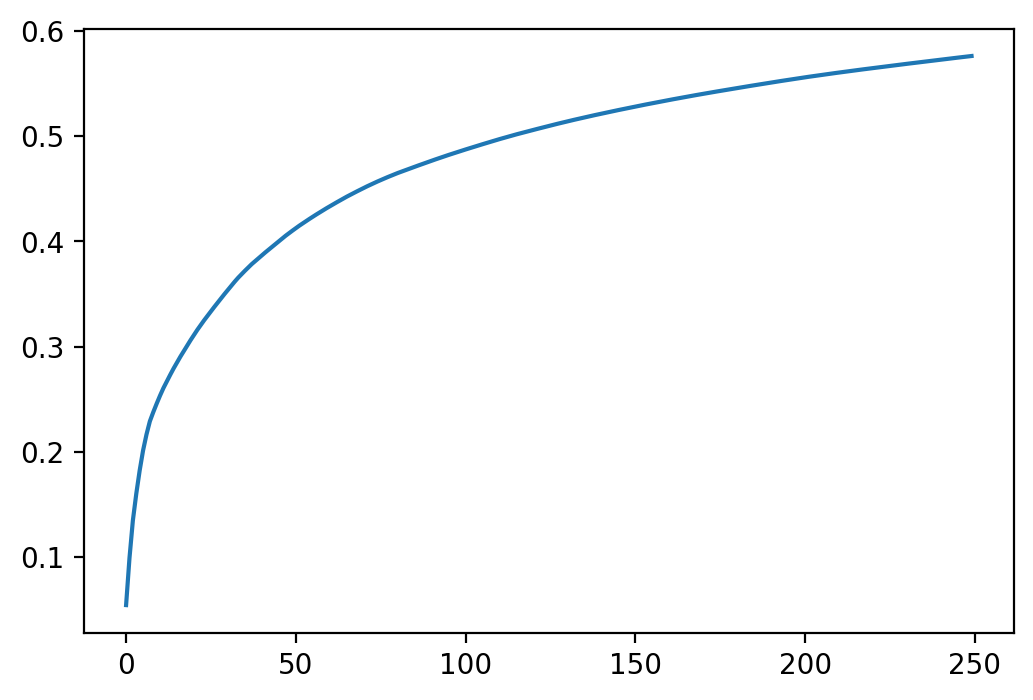

In [116]:
plt.plot(dataset0.token_frequencies_normal_train[:250].values)
plt.gcf().savefig(OUTPUT_DIR / 'token_frequencies.png', dpi=150, bbox_inches='tight')

Print out the corresponding token values:

In [117]:
print([tokenizer.decode(t) for t in dataset0.top_n_tokens_normal_train])

[',', ' the', '.', ' of', ' and', ' to', ' a', ' in', '�', ' that', ' was', ' I', ' is', ' it', ' he', ' his', ' with', ' as', ' for', '-', ';', ' �', '�', ' be', '�', ' had', ' on', '�', ' "', ' you', ' The', ' not', ' at', ' by', ' her', ' which', ' have', ' from', ' but', 's', ' this', ' are', ' were', ' or', ' all', ' they', ' _', ' him', '_', ' one', '--', ' she', ' their', ' an', ' we', ' so', ' my', ' me', '!', '?', ' them', "'s", ' said', ':', ' been', ' would', ' He', ' who', ' will', ' out', ' no', ' there', ' when', ' up', '."', ' more', ' It', ' into', ' if', ' has', 'I', ' man', ' some', ' do', ' time', ' could', ' And', ' its', ' very', ' what', ',"', ' about', ' can', ' than', ' other', ' our', ' But', ' (', ' little', ' your', ' any', ' only', 't', ' A', 'ly', ' like', ' then', ' upon', ' over', ' now', ' two', '—', ' made', ' In', ' may', 'ed', ' us', ' did', ' down', ' should', "'t", ' these', ' before', ' *', ' must', ' great', ' see', ' know', ' such', ' first', ' m

In [118]:
print([tokenizer.decode(t) for t in dataset1.top_n_tokens_normal_train])

[',', ' the', '.', ' of', ' and', ' to', ' a', ' in', '�', ' that', ' was', ' I', ' is', ' it', ' he', ' his', ' with', ' as', ' for', '-', ';', ' �', '�', ' be', '�', ' had', ' on', '�', ' "', ' you', ' The', ' not', ' at', ' by', ' her', ' which', ' have', ' from', ' but', 's', ' this', ' are', ' were', ' or', ' all', ' they', ' _', ' him', '_', ' one', '--', ' she', ' their', ' an', ' we', ' so', ' my', ' me', '!', '?', ' them', "'s", ' said', ':', ' been', ' would', ' He', ' who', ' will', ' out', ' no', ' there', ' when', ' up', '."', ' more', ' It', ' into', ' if', ' has', 'I', ' man', ' some', ' do', ' time', ' could', ' And', ' its', ' very', ' what', ',"', ' about', ' can', ' than', ' other', ' our', ' But', ' (', ' little', ' your']


To reduce the dimensionality of stream embeddings, we initially apply UMAP to a subset of the 1024-dimensional feature vectors that comprise the stream embeddings in the training corpus (where we weight samples based on token frequencies).

Since it is relatively computationally expensive to apply UMAP to unseen feature vectors, we train a feed-forward network as a function approximator; as the target function we use the aforementioned data before and after applying UMAP.

To help assess the fidelity of the described dimensionality reduction, we use K-nearest neighbour classification to predict the token classes of unseen data.

### Apply UMAP

In [119]:
def train(dataset):
    DOWNSAMPLE_FACTOR = 10
    token_ids = dataset.token_ids_normal_train
    embedding_index = dataset.df_normal_train['embedding_index']
    
    np.random.seed(4)
    
    freqs = Counter(np.ravel(token_ids.compressed()))
    inverse_freqs = {k:1/v for k,v in freqs.items()}
    
    compute_weights = np.vectorize(lambda token_id: inverse_freqs[token_id]
                                   if token_id in inverse_freqs.keys() else 0)
    weights = compute_weights(token_ids)
    # Keep weights as plain ndarray; use token_ids.mask for filtering (source of truth for valid tokens)
    
    # Split into train and validation sets
    # NB: This ensures that we separate at the level of text fragments! (It thus might avoid information leakage)
    embedding_index_train, embedding_index_validate, weights_train, weights_validate, token_ids_train, token_ids_validate = model_selection.train_test_split(embedding_index, weights, token_ids, train_size=1000, test_size=1000)
    
    # Use only the first chunk for training
    data_train = Dataset.EMBEDDINGS.get_orthogonal_selection((embedding_index_train, 0))
    data_train = data_train.reshape(-1, data_train.shape[-1])
    token_ids_train = np.ravel(token_ids_train[:, 0])
    weights_train = np.ravel(weights_train[:, 0])
    # Filter: keep only positions where token is in top-K. Use inverse_freqs directly to avoid
    # mask convention issues after train_test_split (mask can be corrupted or inverted).
    token_ids_flat = np.asarray(token_ids_train)  # get underlying data (masked array preserves it)
    valid_mask = np.isin(token_ids_flat, list(inverse_freqs.keys()))
    data_train = data_train[valid_mask]
    token_ids_train = token_ids_train[valid_mask]
    # Recompute weights from inverse_freqs to avoid alignment issues with train_test_split
    weights_train = np.array([inverse_freqs.get(int(t), 0.0) for t in np.asarray(token_ids_train)])
    # Debug: diagnose weights_sum=0
    w_sum = np.sum(weights_train)
    if w_sum == 0:
        print(f'[DEBUG] inverse_freqs len={len(inverse_freqs)}, valid_mask.sum()={valid_mask.sum()}')
        print(f'[DEBUG] weights_train[:5]={weights_train[:5]}, token_ids_train[:5]={np.asarray(token_ids_train[:5])}')
        print(f'[DEBUG] sample in inverse_freqs? {[int(t) in inverse_freqs for t in np.asarray(token_ids_train[:5])]}')
    w_has_nan = np.any(np.isnan(weights_train))
    print(f'[train] after filter: len={len(weights_train)}, weights_sum={w_sum:.6f}, has_nan={w_has_nan}')
    if w_sum == 0 or not np.isfinite(w_sum) or w_has_nan:
        raise ValueError(f'weights_train invalid: sum={w_sum}, has_nan={w_has_nan}')
    # Sample without replacement (this avoids repeated data points), while ensuring approximately balanced sample
    p_train = np.asarray(weights_train, dtype=np.float64) / w_sum
    p_train = p_train / p_train.sum()  # ensure probabilities sum to 1 (fix float rounding)
    I = np.random.choice(len(data_train), size=len(data_train)//DOWNSAMPLE_FACTOR, p=p_train, replace=False)
    data_train = data_train[I]
    token_ids_train = token_ids_train[I]
    
    data_validate = Dataset.EMBEDDINGS.get_orthogonal_selection((embedding_index_validate, 0))
    data_validate = data_validate.reshape(-1, data_validate.shape[-1])
    token_ids_validate = np.ravel(token_ids_validate[:, 0])
    weights_validate = np.ravel(weights_validate[:, 0])
    # Same as train: filter by inverse_freqs (top-K) to avoid mask convention issues
    token_ids_val_flat = np.asarray(token_ids_validate)
    valid_mask_val = np.isin(token_ids_val_flat, list(inverse_freqs.keys()))
    data_validate = data_validate[valid_mask_val]
    token_ids_validate = token_ids_validate[valid_mask_val]
    # Recompute weights from inverse_freqs (same as train, avoid alignment/fill_value issues)
    weights_validate = np.array([inverse_freqs.get(int(t), 0.0) for t in token_ids_val_flat[valid_mask_val]])
    # Debug: check validation weights
    w_val_sum = np.sum(weights_validate)
    w_val_has_nan = np.any(np.isnan(weights_validate))
    print(f'[validate] after filter: len={len(weights_validate)}, weights_sum={w_val_sum:.6f}, has_nan={w_val_has_nan}')
    if w_val_sum == 0 or not np.isfinite(w_val_sum) or w_val_has_nan:
        raise ValueError(f'weights_validate invalid: sum={w_val_sum}, has_nan={w_val_has_nan}')
    # Sample with replacement (we don't require that data points are unique), while ensuring approximately balanced sample
    p_val = np.asarray(weights_validate, dtype=np.float64) / w_val_sum
    p_val = p_val / p_val.sum()  # ensure probabilities sum to 1 (fix float rounding)
    I = np.random.choice(len(data_validate), size=len(data_validate)//DOWNSAMPLE_FACTOR, p=p_val)
    data_validate = data_validate[I]
    token_ids_validate = token_ids_validate[I]
    
    dataset.umap.fit(data_train)
    data_train_transformed = dataset.umap.transform(data_train)
    
    ann = neural_network.MLPRegressor(solver='adam', hidden_layer_sizes=(1024,1024,), verbose=True,
                                      early_stopping=True, max_iter=1000, random_state=23)
    ann.fit(data_train, data_train_transformed)
        
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(ann.predict(data_train), token_ids_train)
    score = knn.score(ann.predict(data_validate), token_ids_validate)

    return score, ann

Use UMAP to reduce the dimensionality of stream embeddings from 1024 to 4 dimensions:

In [120]:
# dataset0.umap = umap.UMAP(n_components=4, min_dist=0.99, n_neighbors=20, random_state=42, transform_seed=23)
# dataset0.score, dataset0.ann = train(dataset0)
# print(dataset0.score)

For exploratory purposes, we furthermore use UMAP to reduce the dimensionality of stream embeddings from 1024 to 2 dimensions:

In [121]:
# dataset1.umap = umap.UMAP(n_components=2, min_dist=0.99, n_neighbors=20, random_state=42, transform_seed=23)
# dataset1.score, dataset1.ann = train(dataset1)
# print(dataset1.score)

We observe that we are able to predict the token class of unseen feature vectors with a classification accuracy exceeding 90%. Given that we have 100 (alternatively 250) possible tokens, this result strongly suggests that dimensionality reduction preserves information about input tokens contained in the original stream embeddings.

Reduce the dimensionality of stream embeddings in the remaining training and testing subsets:

In [122]:
# dataset0.project_embeddings(lambda em: dataset0.ann.predict(em) if len(em) > 0 else np.zeros((0, dataset0.umap.n_components)))
# dataset1.project_embeddings(lambda em: dataset1.ann.predict(em) if len(em) > 0 else np.zeros((0, dataset1.umap.n_components)))

### Apply Random Projections Baseline

As a baseline, randomly project the stream embeddings down to 2 (alternatively 4) dimensions:

In [123]:
# np.random.seed(4)
# dataset2.projection_matrix = np.random.normal(size=(len(dataset2.projection_mean_offset), 2))
# dataset2.project_embeddings(lambda em: (em-dataset2.projection_mean_offset) @ dataset2.projection_matrix)

In [124]:
# np.random.seed(4)
# dataset3.projection_matrix = np.random.normal(size=(len(dataset3.projection_mean_offset), 4))
# dataset3.project_embeddings(lambda em: (em-dataset3.projection_mean_offset) @ dataset3.projection_matrix)

In [125]:
# # save all results above
# with open(Path(DATASET_PATH, 'data', 'embedding_datasets.pkl'), 'wb') as f:
#     pickle.dump((dataset0, dataset1, dataset2, dataset3), f, protocol=pickle.HIGHEST_PROTOCOL)

### Explore Dimensionality-Reduced Stream Embeddings

In [126]:
def plot_encodings(dataset1, cluster_label_map=None, n_samples=3*10**5,
                   dbscan_max_num_subclusters=3, dbscan_eps=0.3, include_labels=True):
    
    encodings = np.vstack([np.vstack(encodings) for encodings in dataset1.embeddings_projected_normal_train])
    encodings = encodings[:, :2]
    
    cluster_assignments = np.ravel(dataset1.token_ids_normal_train)
    cluster_assignments = cluster_assignments[~cluster_assignments.mask]

    I = np.random.choice(len(cluster_assignments), size=n_samples)
    cluster_assignments = cluster_assignments[I]
    encodings = encodings[I]
    
    clusters = np.unique(cluster_assignments)
    
    cmap = matplotlib.cm.get_cmap(name='tab20b')
    colors = cmap(np.linspace(0, 1, len(clusters)))
    color_map = {k: colors[i] for i, k in enumerate(clusters)}

    for c in cluster_assignments:
        color_map[c]

    scatter = plt.scatter(*encodings.T.tolist(), c=[color_map[c] for c in cluster_assignments],
                          label=cluster_assignments, s=0.2, alpha=0.5)
    
    if include_labels:
        for cluster, cluster_label in zip(clusters, range(1, len(clusters)+1)):
            cluster_encodings = encodings[cluster_assignments == cluster]

            sub_clustering = sklearn.cluster.DBSCAN(min_samples=len(cluster_encodings)//dbscan_max_num_subclusters,
                                                    eps=dbscan_eps).fit(cluster_encodings)

            for s in np.unique(sub_clustering.labels_):
                sub_cluster_encodings = cluster_encodings[sub_clustering.labels_ == s]
                plt.text(*np.mean(sub_cluster_encodings, axis=0),
                         str(cluster_label), horizontalalignment='center', fontsize=6)
            
    if cluster_label_map:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.gcf().text(0.92, 1.0, '\n'.join([' '.join(['{}: {}'.format(n*2+1+i, cluster_label_map[c])
                                              for i, c in enumerate(cs)])
                                              for n, cs in enumerate(np.reshape(clusters, (-1, 2)))]),
                       fontsize=5, verticalalignment='top', horizontalalignment='left', bbox=props)

Plot the (2D) feature vectors comprising the dimensionality-reduced stream embeddings. For visualisation purposes, we apply a clustering algorithm to the subset of feature vectors associated with a given token. We then plot a label identifying the token at each cluster centroid. (Colours merely serve to better distinguish between tokens; note that there is a many-to-one mapping between tokens and colours, due to the limited palette.)

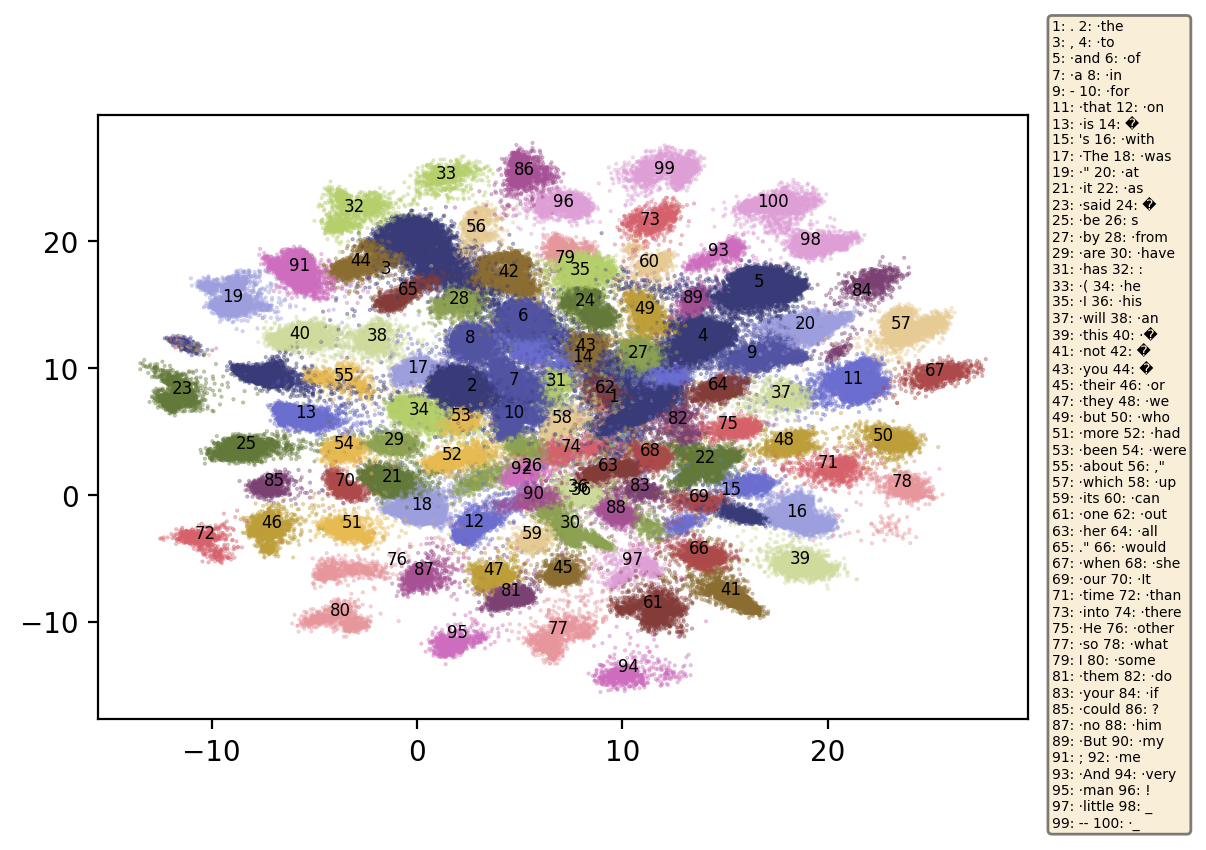

In [127]:
plot_encodings(dataset1, cluster_label_map={t:tokenizer.decode(t).replace(' ', '·')
                                            for t in dataset1.top_n_tokens_normal_train})
plt.gcf().savefig(OUTPUT_DIR / 'encodings_dataset1_umap.png', dpi=150, bbox_inches='tight')

As observed, UMAP strongly clusters feature vectors according to their associated input tokens. In addition, we observe some evidence that feature vectors are clustered together based on proximate meaning; from the legend, we see that:
* Clusters corresponding to tokens 48 and 45 (*we* and *their*) are adjacent
* Clusters corresponding to tokens 54 and 18 (*were* and *was*) are adjacent
* Clusters corresponding to tokens 86 and 62 (*him* and *her*) are adjacent

etc.

By contrast, if we randomly project the stream embeddings, we observe no such clustering behaviour. Thus, UMAP-transformed stream embeddings appear to better preserve meaning compared to random projections.

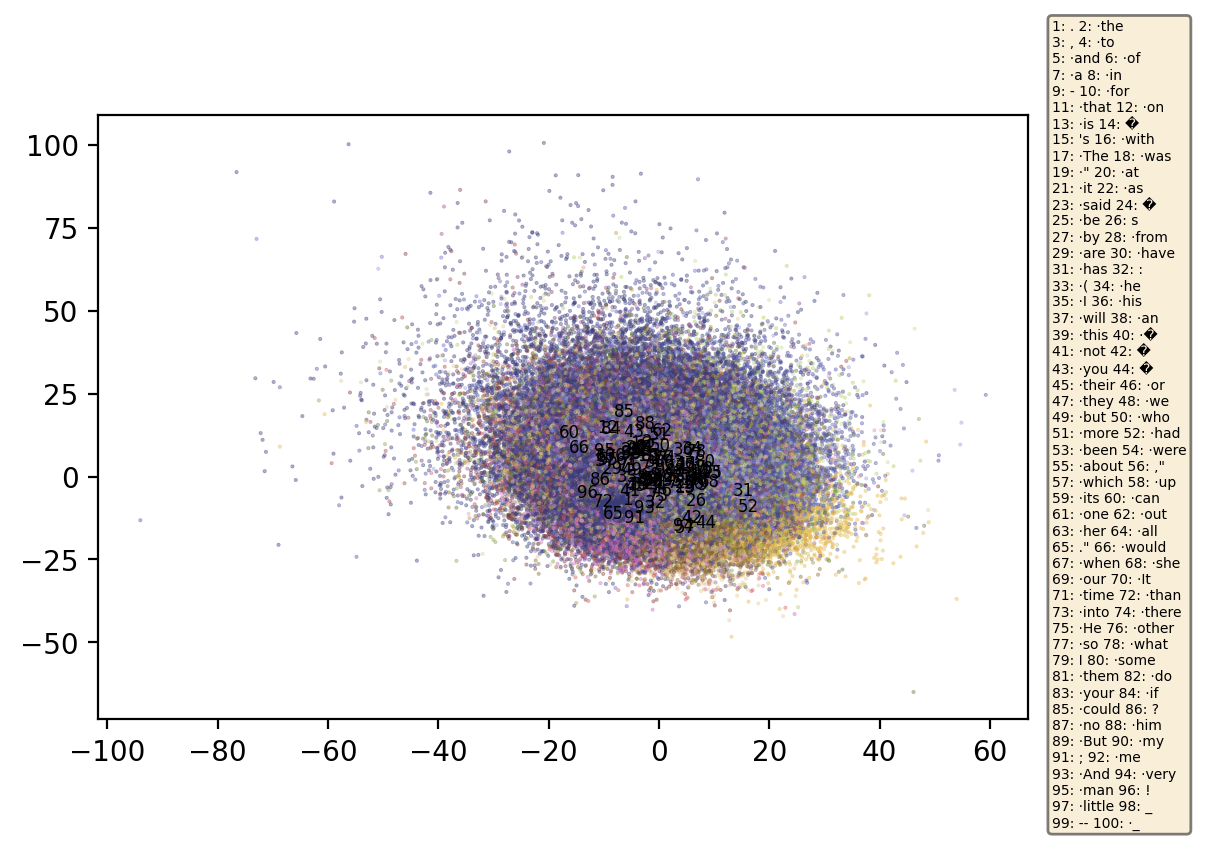

In [128]:
plot_encodings(dataset2, cluster_label_map={t:tokenizer.decode(t).replace(' ', '·') for t in dataset2.top_n_tokens_normal_train})
plt.gcf().savefig(OUTPUT_DIR / 'encodings_dataset2_random_proj.png', dpi=150, bbox_inches='tight')

Exploring the effect of projecting the stream embeddings down to 4 dimensions is slightly more challenging from a visualisation perspective. We adopt the following approach:
* Partition the set of 250 tokens into training and testing subsets.
* Using the feature vectors associated with the training subset, construct a K-nearest neighbour classifier, taking the tokens as labels.
* For each token in the testing subset and for each associated feature vector, predict its token based on the feature vector.
* For each token in the testing subset, display the most frequently predicted token alongside the relative number of times it was predicted.

In [129]:
embeddings_projected_normal_train = np.vstack([np.vstack(encodings) for encodings in dataset0.embeddings_projected_normal_train])

token_ids_normal_train = np.ravel(dataset0.token_ids_normal_train)
token_ids_normal_train = token_ids_normal_train[~token_ids_normal_train.mask]

np.random.seed(6)
I = np.random.choice(len(token_ids_normal_train), size=10**6)
embeddings_projected_normal_train = embeddings_projected_normal_train[I]
token_ids_normal_train = token_ids_normal_train[I]

token_ids_normal_train_map = {k:v for k, v in Counter(token_ids_normal_train).items()}
token_ids_normal_train_map = {k:v for k, v in token_ids_normal_train_map.items() if v >= 100}

_, token_ids_test = model_selection.train_test_split(list(token_ids_normal_train_map.keys()), test_size=100)
I_train = [t not in set(token_ids_test) for t in token_ids_normal_train]
I_test = [t in set(token_ids_test) for t in token_ids_normal_train]

freqs = Counter(token_ids_normal_train[I_train])
inverse_freqs = {k:1/v for k,v in freqs.items()}
weights = np.array([inverse_freqs[c] for c in token_ids_normal_train[I_train]])
I = np.random.choice(len(weights), size=len(weights), p=weights/sum(weights))

In [130]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance',
                                             n_jobs=4).fit(embeddings_projected_normal_train[I_train][I],
                                                           token_ids_normal_train[I_train][I])
predicted_tokens = knn.predict(embeddings_projected_normal_train[I_test])

In [131]:
def display_predicted_tokens():
    np.random.seed(5)
    
    predicted_tokens_map = {t: Counter(predicted_tokens[token_ids_normal_train[I_test] == t])
                            for t in token_ids_test}
    total_counts = {k: sum(v.values()) for k, v in predicted_tokens_map.items()}
    
    predicted_tokens_map = {tokenizer.decode(k).replace(' ', '·'): [(tokenizer.decode(t).replace(' ', '·'),
                                                                     np.round(count/total_counts[k], 3))
                                                                    for t, count in v.most_common(1)]
                            for k, v, in predicted_tokens_map.items()}
    
    return predicted_tokens_map
    
predicted_tokens_map = display_predicted_tokens()

In [132]:
df_nearest_neighbours = pd.DataFrame(predicted_tokens_map).T
df_nearest_neighbours['Top Prediction'] = df_nearest_neighbours[0].apply(lambda t: t[0])
df_nearest_neighbours['Score'] = df_nearest_neighbours[0].apply(lambda t: t[1])
del df_nearest_neighbours[0]
df_nearest_neighbours.sort_values(by='Score', inplace=True, ascending=False)

pd.set_option('display.max_rows', df_nearest_neighbours.shape[0]+1)
df_nearest_neighbours.index.name = 'Actual Label'
df_nearest_neighbours[df_nearest_neighbours['Score'] > 0.5]

,Top Prediction,Score
Actual Label,,
"?""",".""",0.988
·think,·thought,0.988
·Then,·then,0.987
·don,·can,0.984
't,·few,0.981
·than,·only,0.981
·|,·though,0.980
·if,·If,0.980
·said,·though,0.979


From the preceding table, we observe additional evidence that when we apply UMAP, feature vectors whose associated tokens are distinct but share similar meaning are close in Euclidean space.

## Compute Path Signatures and Evaluate Anomaly Detection Performance

Finally, we evaluate the performance of training an anomaly detector, where we represent each dimensionality-reduced stream embedding using its path signature. (As a preprocessing step, we apply the cumulative sum transformation to each dimensionality-reduced stream embedding.)

Recall that we operate on chunks of text, each consisting of 512 tokens. To obtain a single anomaly score for a given work of interest $W$ (represented as multiple text chunks), we proceed as follows:
* Compute signatures for all available dimensionality-reduced stream embeddings (with one signature for each chunk).
* Use a random subset of signatures in the training corpus to train an anomaly detection model (isolation forest).
* Use the remaining subset of signatures in the training corpus to calibrate the anomaly detector. Calibration is achieved by scoring each of the signatures and computing the empirical cumulative distribution of anomaly scores $F_1$.
* Compute anomaly scores for each of the signatures corresponding to the work of interest $W$. The set of scores specifies an empirical cumulative distribution of anomaly scores $F_2$.
* Apply a (one-sided) Kolmogorov-Smirnoff test to distributions $F_1$, $F_2$. Use the resulting p value to decide whether to treat the work of interest $W$ as anomalous.

In [133]:
class IFScorer():
    NAME = 'IsoFor'
    def __init__(self):
        self.model = ensemble.IsolationForest()

    def fit(self, normal_signatures_train):        
        self.model.fit(normal_signatures_train)
        
    def score_samples(self, signatures):
        return self.model.score_samples(signatures)

In [134]:
def compute_signature(path, truncation_level=2, cumsum_transform=True):
    path = np.vstack((np.zeros((2, path.shape[1])), path))
        
    if cumsum_transform:
        path = np.cumsum(path, axis=0)

    signature = iisignature.sig(path, truncation_level)
        
    return signature

def compute_signatures(paths, truncation_level):
    signatures = {i: np.atleast_2d([compute_signature(q, truncation_level) for q in p])
                      for i, p in enumerate(paths)}
    
    return pd.Series(signatures)

In [135]:
def compute_anomaly_scores(truncation_level=1,
                           random_seed=4,
                           scoring_classes=(IFScorer,),
                           normal_paths_train=None,
                           normal_paths_test=None,
                           anomalous_paths={'fr': None,
                                            'de': None},
                           max_train_size=100,
                           max_test_size=100):

    def _compute_signatures(paths):
        return compute_signatures(paths, truncation_level)

    np.random.seed(random_seed)

    def random_sample(paths, max_size):
        N = len(paths)
        I = np.random.choice(N, size=min([N, max_size]), replace=False)
        
        return [paths[i] for i in I if len(paths[i]) > 0]
    
    normal_paths_train = random_sample(normal_paths_train, max_train_size)
    
    normal_paths_test = random_sample(normal_paths_test, max_test_size)    
    anomalous_paths = {lang: random_sample(paths, max_test_size) for lang, paths in anomalous_paths.items()}
    
    normal_signatures_train = _compute_signatures(normal_paths_train)
    normal_signatures_train = np.array(normal_signatures_train.values.tolist())
        
    normal_signatures_test = np.array(_compute_signatures(normal_paths_test).values.tolist())
    normal_signatures_test, normal_signatures_test__score_calibration = \
        model_selection.train_test_split(normal_signatures_test, train_size=0.5)
    anomalous_signatures = {lang: _compute_signatures(paths) for lang, paths in anomalous_paths.items()}
        
    scores_normal = {}
    scores_anomalous = {}
    for score_class in scoring_classes:
        model = score_class()
        model.fit(normal_signatures_train.reshape(-1, normal_signatures_train.shape[-1]))
        
        raw_scorer = lambda samples: model.score_samples(samples.reshape(-1, normal_signatures_train.shape[-1])).reshape(-1, 10)
        calibration_scores = sorted(np.ravel(raw_scorer(normal_signatures_test__score_calibration)))
        probability_scorer = lambda samples: [scipy.stats.ks_2samp(calibration_scores, score_block, mode='exact', alternative='less').pvalue for score_block in raw_scorer(samples)]
        
        scores_normal[score_class.NAME] = probability_scorer(normal_signatures_test)
        scores_anomalous[score_class.NAME] = \
            {'_'.join((model.NAME, lang)): probability_scorer(np.array(sigs.values.tolist()))
                            for lang, sigs in anomalous_signatures.items()}
    
    return scores_normal, scores_anomalous, normal_signatures_train.shape[-1]

Apply UMAP to stream embeddings (considering 250 most frequent tokens) to obtain 4-dimensional stream embeddings, then compute signatures up to level 4:

In [136]:
def evaluate_anomaly_scores_vs_signature_length(normal_paths_train, normal_paths_test, anomalous_paths,
                                                truncation_level=range(1, 5), n_repetitions=1):
    results = defaultdict(dict)
    for l in truncation_level:
        print('Computing scores for signature level {}'.format(l))
        results['no_projection'][l] = [compute_anomaly_scores(truncation_level=l,
                                                              normal_paths_train=normal_paths_train,
                                                              normal_paths_test=normal_paths_test,
                                                              anomalous_paths=anomalous_paths,
                                                              max_train_size=10**8, max_test_size=1000)
                                                              for i in range(n_repetitions)]

    return results

dataset0.results = evaluate_anomaly_scores_vs_signature_length(dataset0.embeddings_projected_normal_train,
                                                               dataset0.embeddings_projected_normal_eval,
                                                             {'impostor': dataset0.embeddings_projected_impostor})

with open('results0.pkl', 'wb') as f:
    pickle.dump(dataset0.results, f)

Computing scores for signature level 1


Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


Quantify performance using receiver operating characteristic area under the curve (ROCAUC):

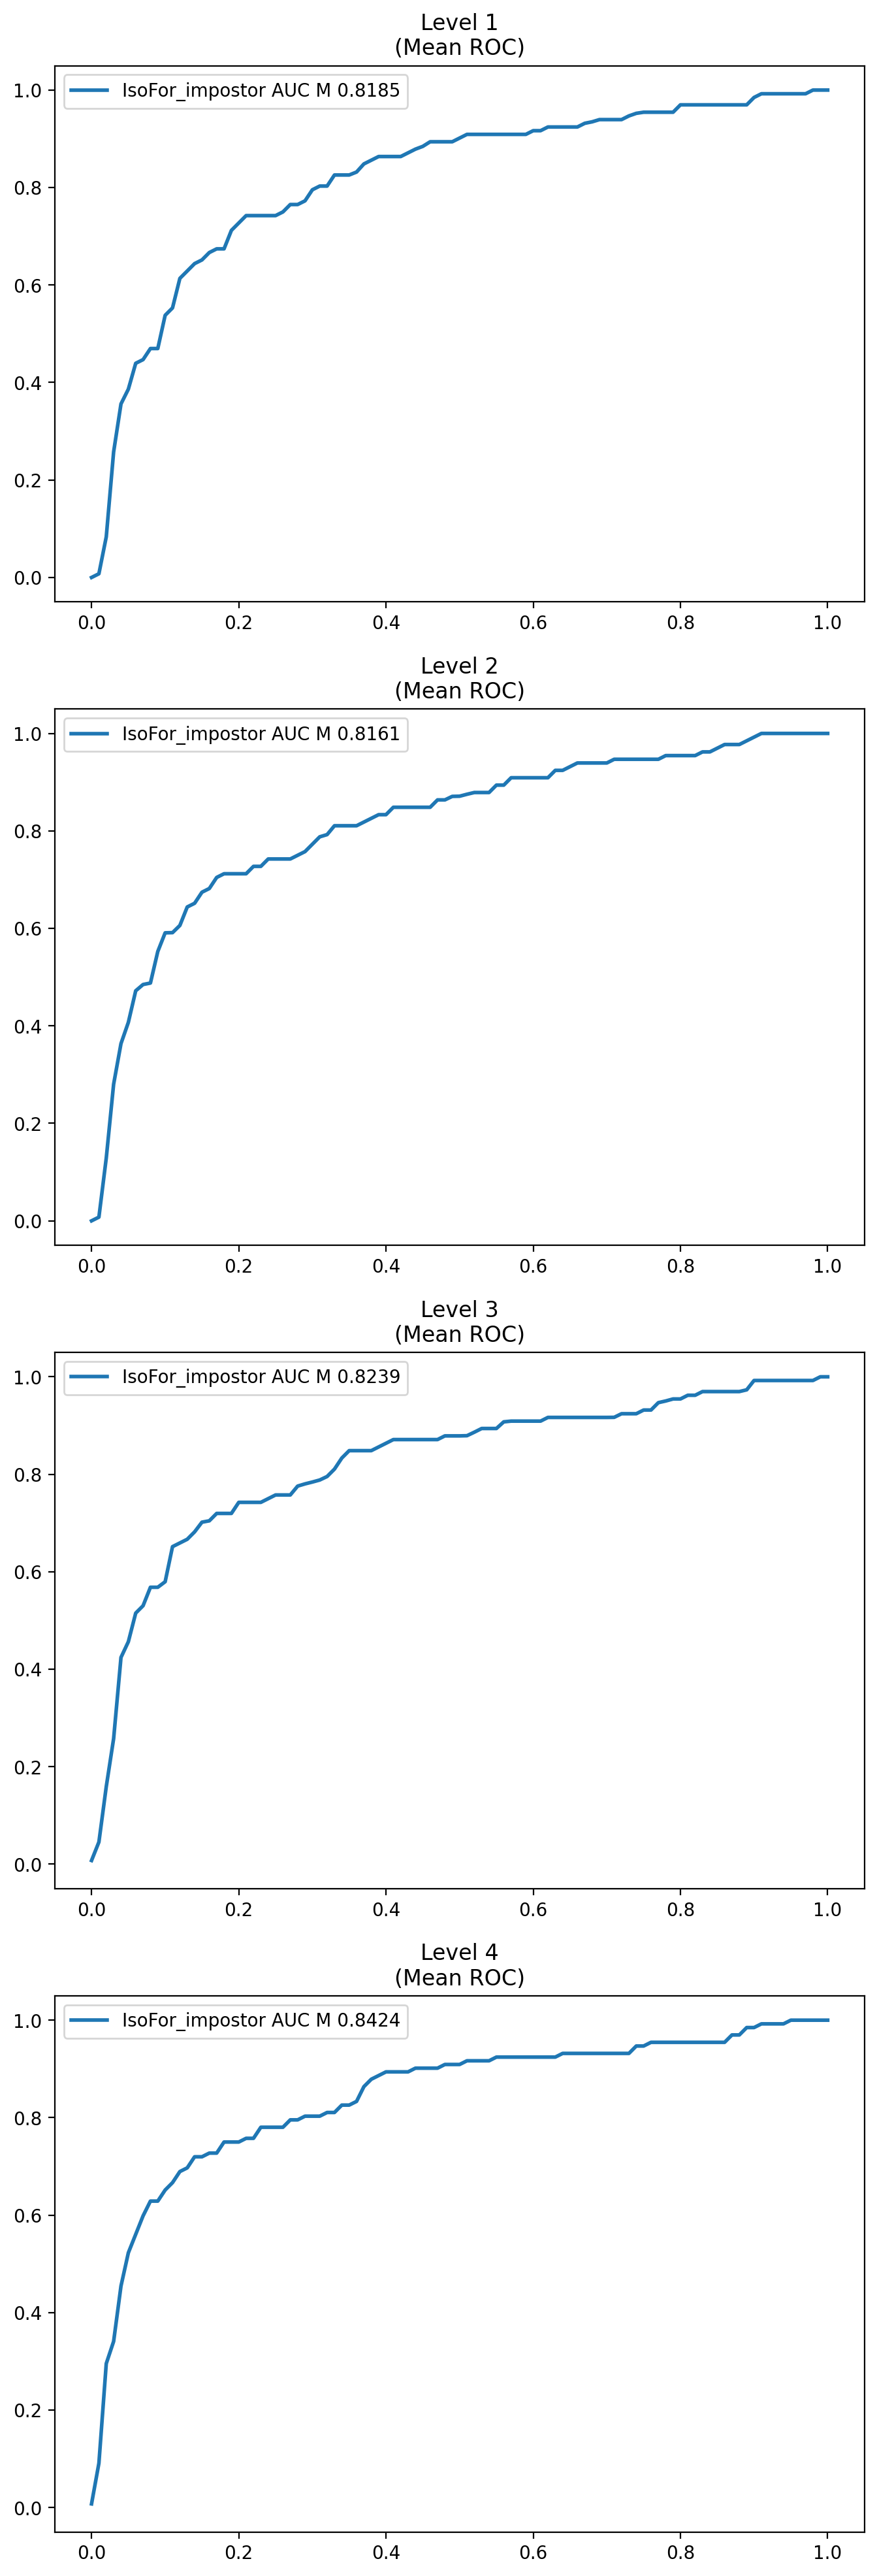

In [137]:
def plot_roc(results):
    def _plot_results(ax, normal_scores, anomalous_scores):
        
        for scoring_method in anomalous_scores.keys():
            all_labels, all_scores = list(zip(*list(anomalous_scores[scoring_method].items())))

            for label, anomalous_scores_subset in zip(all_labels, all_scores):
                tpr_all = []; roc_all = []
                base_fpr = np.linspace(0, 1, 101)

                fpr, tpr, _ = metrics.roc_curve([False] * len(normal_scores[scoring_method]) + [True] * len(anomalous_scores_subset),
                                                 -1 * np.append(normal_scores[scoring_method], anomalous_scores_subset))
                roc = metrics.auc(fpr, tpr)
                tpr = np.interp(base_fpr, fpr, tpr)

                tpr_all.append(tpr)
                roc_all.append(roc)

                ax.plot(base_fpr, np.mean(tpr_all, axis=0), lw=2,
                        label='{} AUC M {:.4f}'.format(label, np.mean(roc_all)))
        ax.legend()
    
    levels = results.keys()
        
    _, axs = plt.subplots(nrows=1, ncols=len(set(levels)), figsize=(20, 5), sharey=True)
    axs = np.atleast_1d(axs)
    
    for j, level in zip(range(len(set(levels))), sorted(set(levels))):
        _plot_results(axs[j], results[level][0][0], results[level][0][1])
        axs[j].set_title('Level {}\n(Mean ROC)'.format(level))
    plt.tight_layout()

plot_roc(dataset0.results['no_projection'])
plt.gcf().savefig(OUTPUT_DIR / 'roc_dataset0_no_projection.png', dpi=150, bbox_inches='tight')

As observed, using signatures truncated at level 4, we obtain an ROCAUC of 92%.

Next, evaluate the alternative approach of applying UMAP to stream embeddings (but considering 100 most frequent tokens) to obtain 2-dimensional stream embeddings, then computing signatures up to level 4:

In [138]:
dataset1.results = evaluate_anomaly_scores_vs_signature_length(dataset1.embeddings_projected_normal_train,
                                                               dataset1.embeddings_projected_normal_eval,
                                                             {'impostor': dataset1.embeddings_projected_impostor})

Computing scores for signature level 1


Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


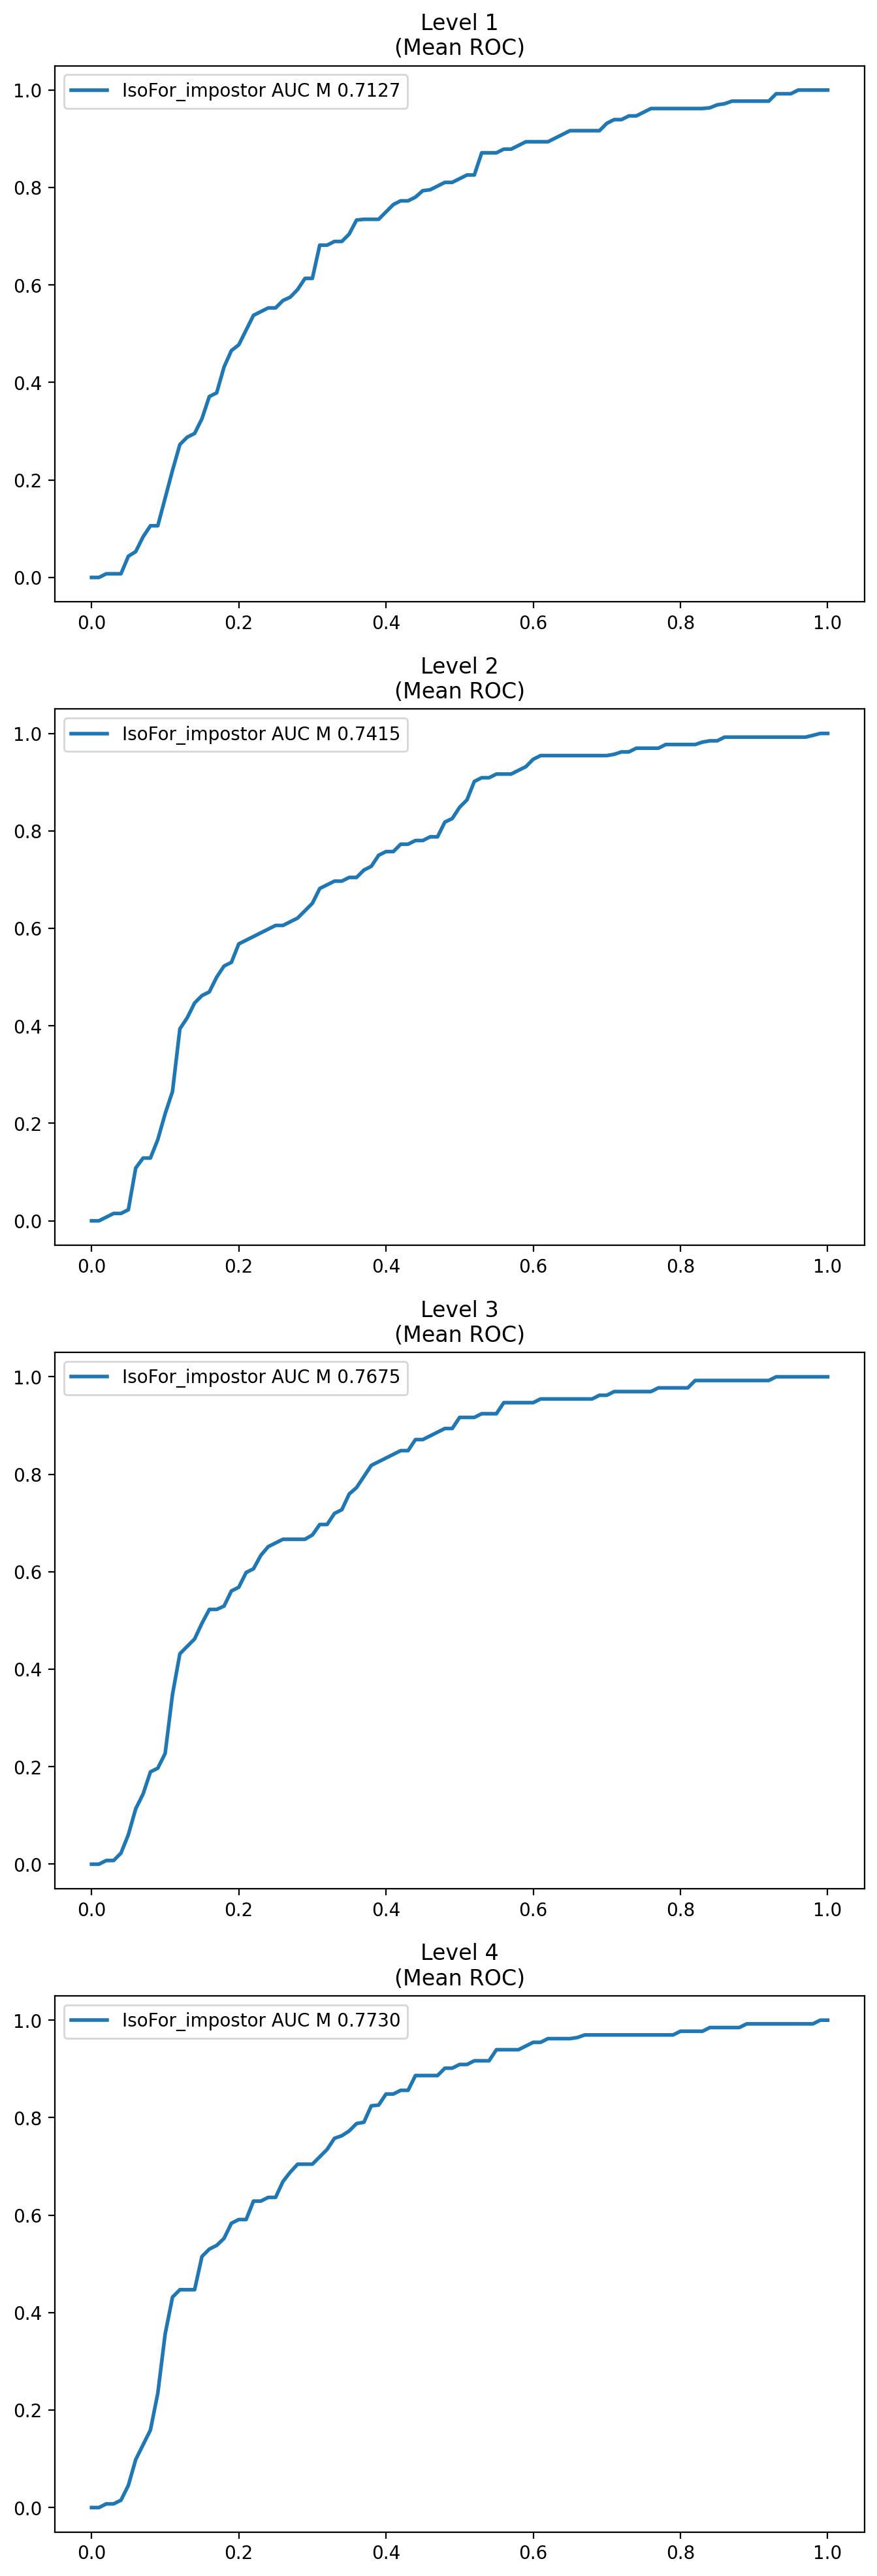

In [139]:
plot_roc(dataset1.results['no_projection'])
plt.gcf().savefig(OUTPUT_DIR / 'roc_dataset1_no_projection.png', dpi=150, bbox_inches='tight')

In [140]:
# Random Projection K=100, 2d: 与 dataset1 (UMAP 2d) 对应的 baseline
dataset2.results = evaluate_anomaly_scores_vs_signature_length(dataset2.embeddings_projected_normal_train,
                                                               dataset2.embeddings_projected_normal_eval,
                                                             {'impostor': dataset2.embeddings_projected_impostor})

Computing scores for signature level 1
Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


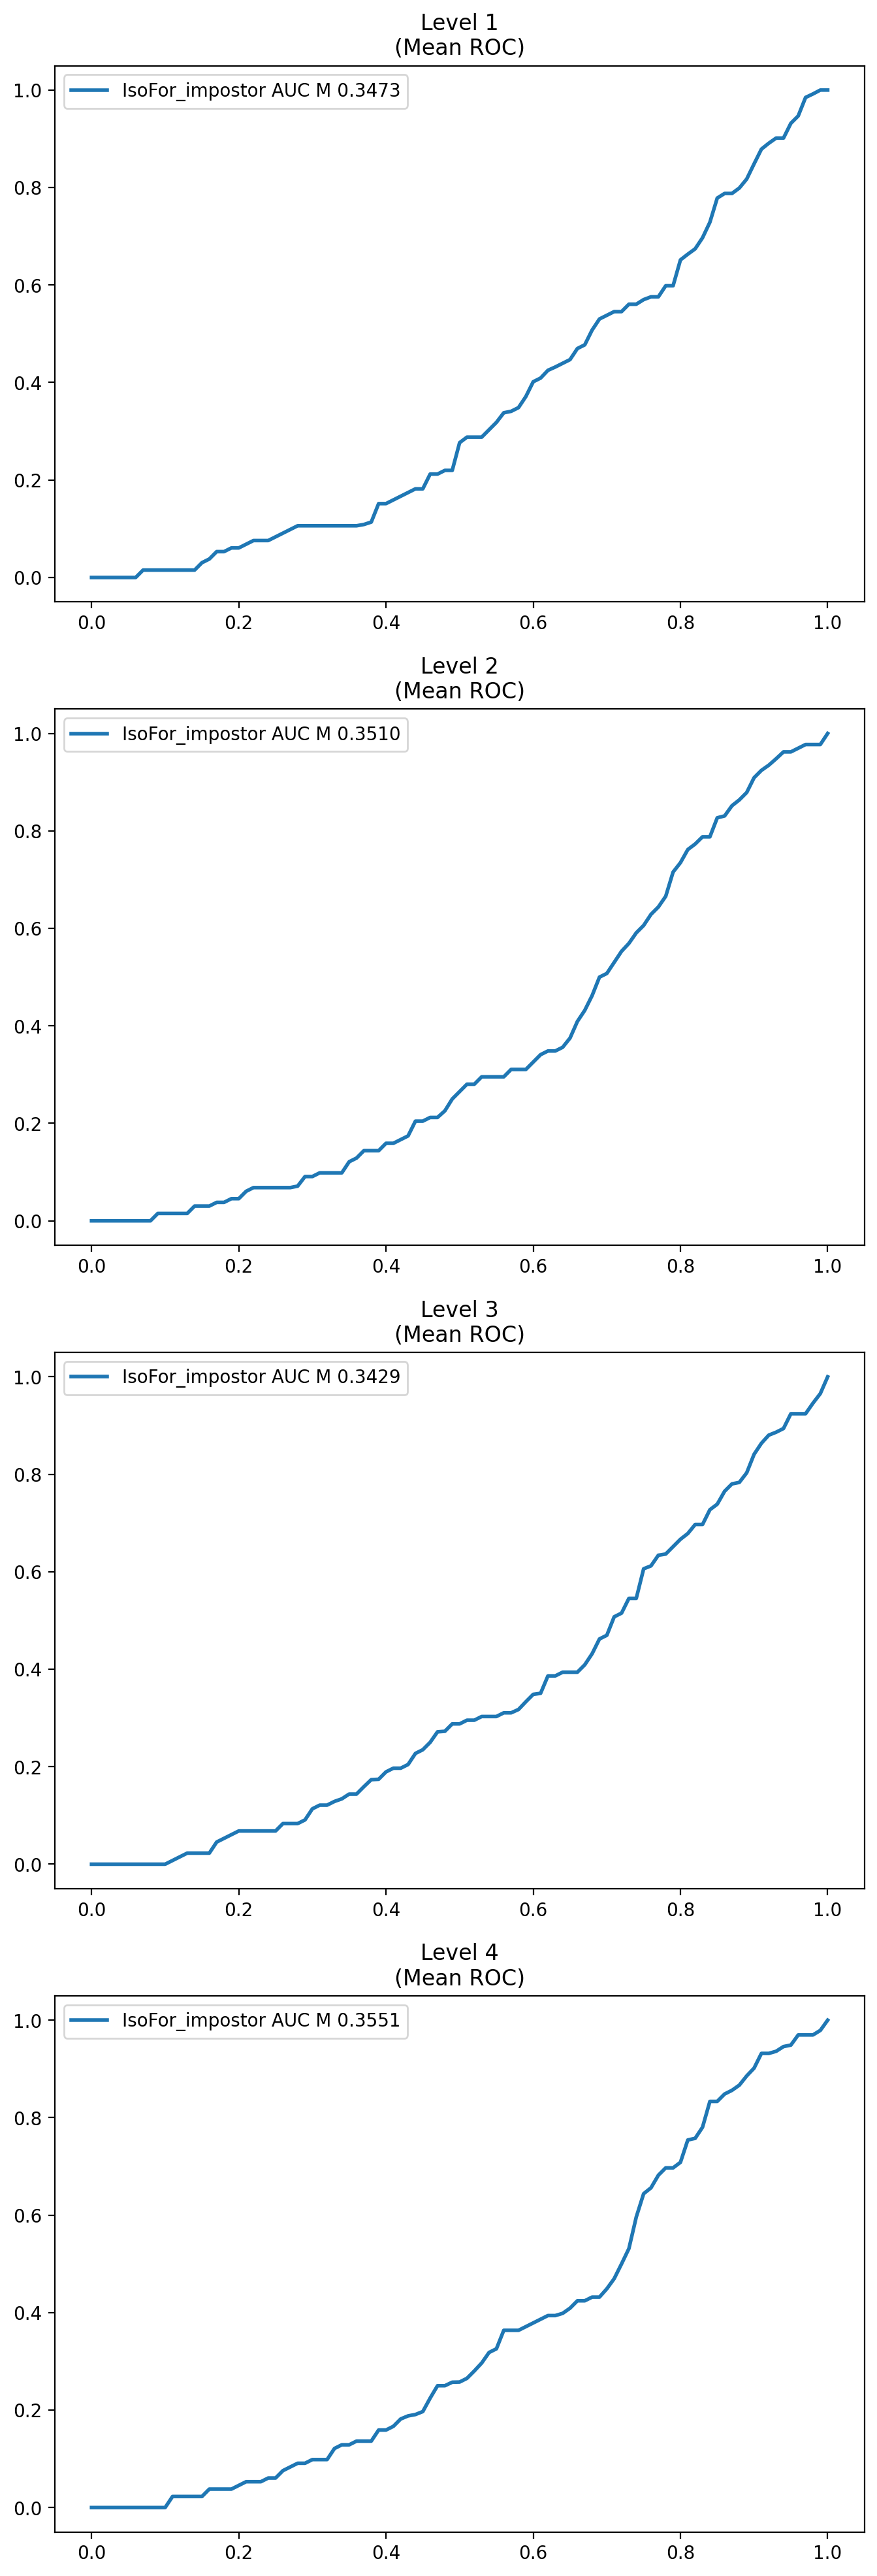

In [141]:
plot_roc(dataset2.results['no_projection'])
plt.gcf().savefig(OUTPUT_DIR / 'roc_dataset2_no_projection.png', dpi=150, bbox_inches='tight')

As observed, performance using 250 most frequent tokens is superior to that when using 100 most frequent tokens (92% vs. 69% ROCAUC).

Finally, compare results using UMAP to the random projections baseline (considering 250 most frequent tokens):

In [142]:
dataset3.results = evaluate_anomaly_scores_vs_signature_length(dataset3.embeddings_projected_normal_train,
                                                               dataset3.embeddings_projected_normal_eval,
                                                             {'impostor': dataset3.embeddings_projected_impostor})

Computing scores for signature level 1


Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


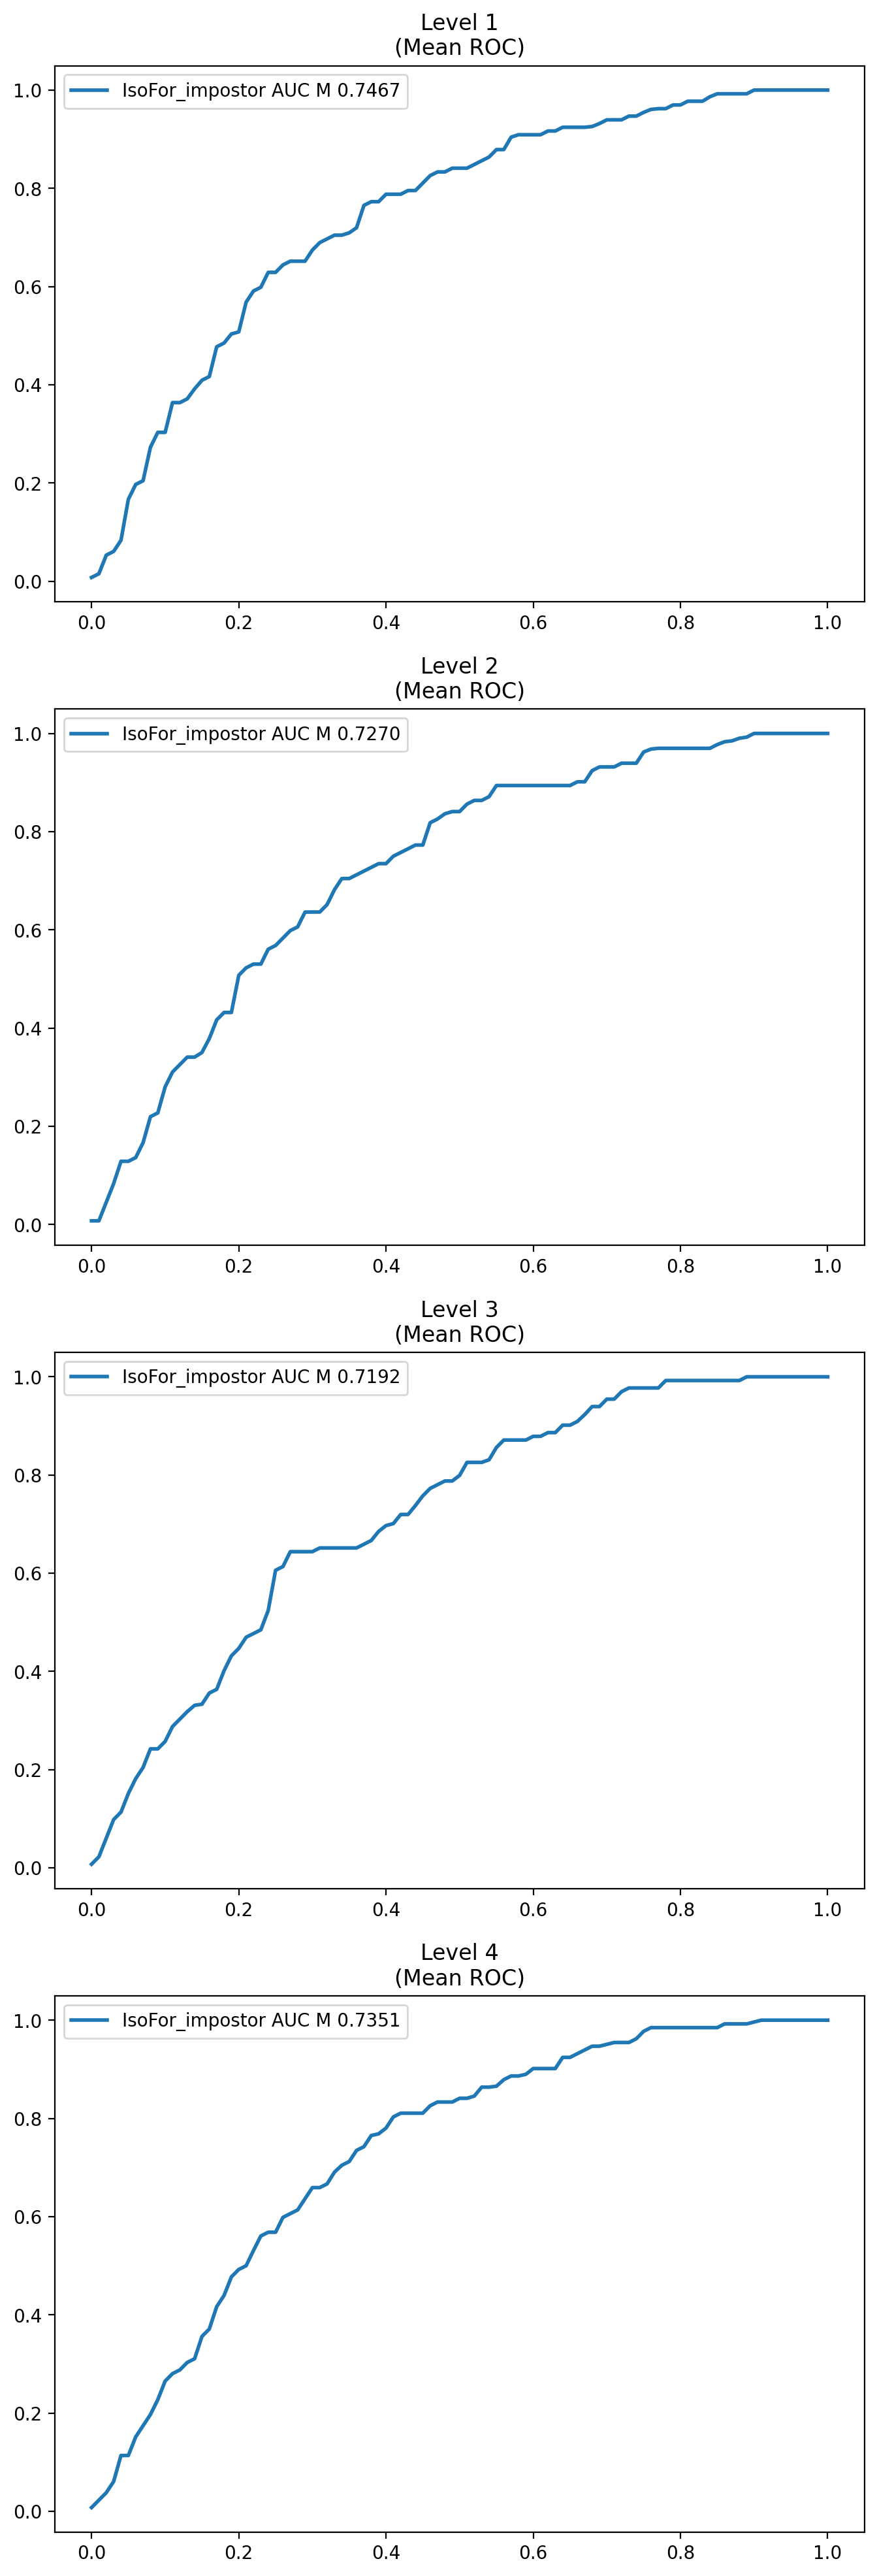

In [143]:
plot_roc(dataset3.results['no_projection'])
plt.gcf().savefig(OUTPUT_DIR / 'roc_dataset3_no_projection.png', dpi=150, bbox_inches='tight')

# Print and save AUC metrics to output/
def print_auc_metrics(results):
    aucs = {}
    for level in sorted(results.keys()):
        normal_scores, anomalous_scores = results[level][0][0], results[level][0][1]
        roc_all = []
        for scoring_method in anomalous_scores.keys():
            all_labels, all_scores = list(zip(*list(anomalous_scores[scoring_method].items())))
            for label, anomalous_scores_subset in zip(all_labels, all_scores):
                fpr, tpr, _ = metrics.roc_curve(
                    [False] * len(normal_scores[scoring_method]) + [True] * len(anomalous_scores_subset),
                    -1 * np.append(normal_scores[scoring_method], anomalous_scores_subset))
                roc_all.append(metrics.auc(fpr, tpr))
        aucs[level] = np.mean(roc_all) if roc_all else 0
    return aucs

datasets = [dataset0, dataset1, dataset2, dataset3]
all_aucs = {d: print_auc_metrics(d.results['no_projection']) for d in datasets}
print('ROC AUC (no_projection, IsoFor):')
print('Level | dataset0   | dataset1   | dataset2   | dataset3')
print('------+------------+------------+------------+------------')
for level in sorted(all_aucs[dataset0].keys()):
    row = ' | '.join(f'{all_aucs[d].get(level, 0):.4f}     ' for d in datasets)
    print(f'{level:5} | {row}')

metrics_dict = {'dataset0': all_aucs[dataset0], 'dataset1': all_aucs[dataset1], 
                'dataset2': all_aucs[dataset2], 'dataset3': all_aucs[dataset3]}
import json
with open(OUTPUT_DIR / 'roc_auc_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)
pd.DataFrame(metrics_dict).to_csv(OUTPUT_DIR / 'roc_auc_metrics.csv', index=True, index_label='Level')
print(f'Saved to {OUTPUT_DIR}/roc_auc_metrics.json and roc_auc_metrics.csv')

